# Background
We have now made dark mode available as part of the "accessibility for reading" beta feature. Dark mode appears as an option under the appearance menu on the page. We would like to know how people are using dark mode

Answer the following questions:

- What percentage of users have changed their color theme?
- What were they most likely to change it towards?
- Of all clicks to the color section of the new menu, what percentage is for each color option?
- Were there any other interesting observations around the usage of the color menu?
  

QA ticket: [T356335](https://phabricator.wikimedia.org/T356335)    
Analysis ticket: [T365143](https://phabricator.wikimedia.org/T365143)  
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__  
Analysis date: May 21 - May 28, 2024   



#  Instrumentation Note


__Appearance menu on sidebar__    
<img src="Pictures/Appearance_menu_sidebar.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__Appearance menu in a dropdown menu__    
<img src="Pictures/Appearance_menu_dropdown.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    

Appearance menu can be located on the sidebar or in the dropdown menu.    
Click events and color values are captured in `event.desktopwebuiactionstracking` schema. 
`event.dark_mode_setting` field captures the initial color value when the event is triggered.`event.name` field captures the color option that users click on.   

__Vector-2022, mapping table of color options and values in schema__ 
| Color options | event.name                              | event.dark_mode_setting |
|---------------|-----------------------------------------|-------------------|
| Light         | skin-client-pref-skin-theme-value-day   | 0                 |
| Dark          | skin-client-pref-skin-theme-value-night | 1                 |
| Automatic      | skin-client-pref-skin-theme-value-os    | 2                 |

| event.dark_mode_setting | event.is_dark_mode_prepared_by_os | event.is_dark_mode_on | Actual color theme |
|-------------------|-----------------------------|-----------------|---------------------|
| 0 (Light)         | TRUE/FALSE                  | FALSE           | Light               |
| 1 (Dark)          | TRUE/FALSE                  | TRUE            | Dark                |
| 2 (Automatic)      | TRUE                        | TRUE            | Dark                |
| 2 (Automatic)      | FALSE                       | FALSE           | Light               |

__Default setting__  
Default is 2 for desktop beta. 0 for mobile.

The click on `move to sidebar` is captured as `event.name=pinnable-header.vector-appearance.pin and event.action=click`  
The click on `hide` is captured as `event.name=pinnable-header.vector-appearance.unpin and event.action=click`  
The clicks on the readability icon is caputured as `event.name=ui.dropdown-vector-appearance-dropdown and event.action=click`   


# Analysis

In [3]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(glue)

In [4]:
library(jsonlite)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [5]:
Sys.setenv(RETICULATE_PYTHON = "/home/jiawang/.conda/envs/2024-03-12T22.43.58_jiawang/bin/python")

In [6]:
library(reticulate)

In [7]:
library(wmfdata)

In [8]:
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()

In [9]:
 use_condaenv(conda_env_data[['active_prefix']])

In [10]:
 
wmfdata <- import('wmfdata')

In [11]:
options(repr.plot.width = 15, repr.plot.height = 10)

## Of all clicks to the color section of the new menu, what percentage is for each color option?

###  Daily trend

In [13]:
query <- "
SELECT  date_format(dt, 'yyyy-MM-dd') AS event_date,
event.name,
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month>=5 
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-skin-theme-value-%' 
AND NOT useragent.is_bot
AND NOT event.isAnon
GROUP BY date_format(dt, 'yyyy-MM-dd') , event.name
"

In [14]:
 df_daily <- wmfdata$spark$run(query)

In [16]:
df_daily$event_date <- as.Date(df_daily$event_date)

In [19]:
df_daily <- df_daily %>%
  mutate(
      event_name=case_when(
          name=='skin-client-pref-skin-theme-value-os' ~ 'automatic-theme',
          name=='skin-client-pref-skin-theme-value-day' ~ 'day-theme',
          name=='skin-client-pref-skin-theme-value-night' ~ 'night-theme',
          TRUE ~ 'others'
          )
      )

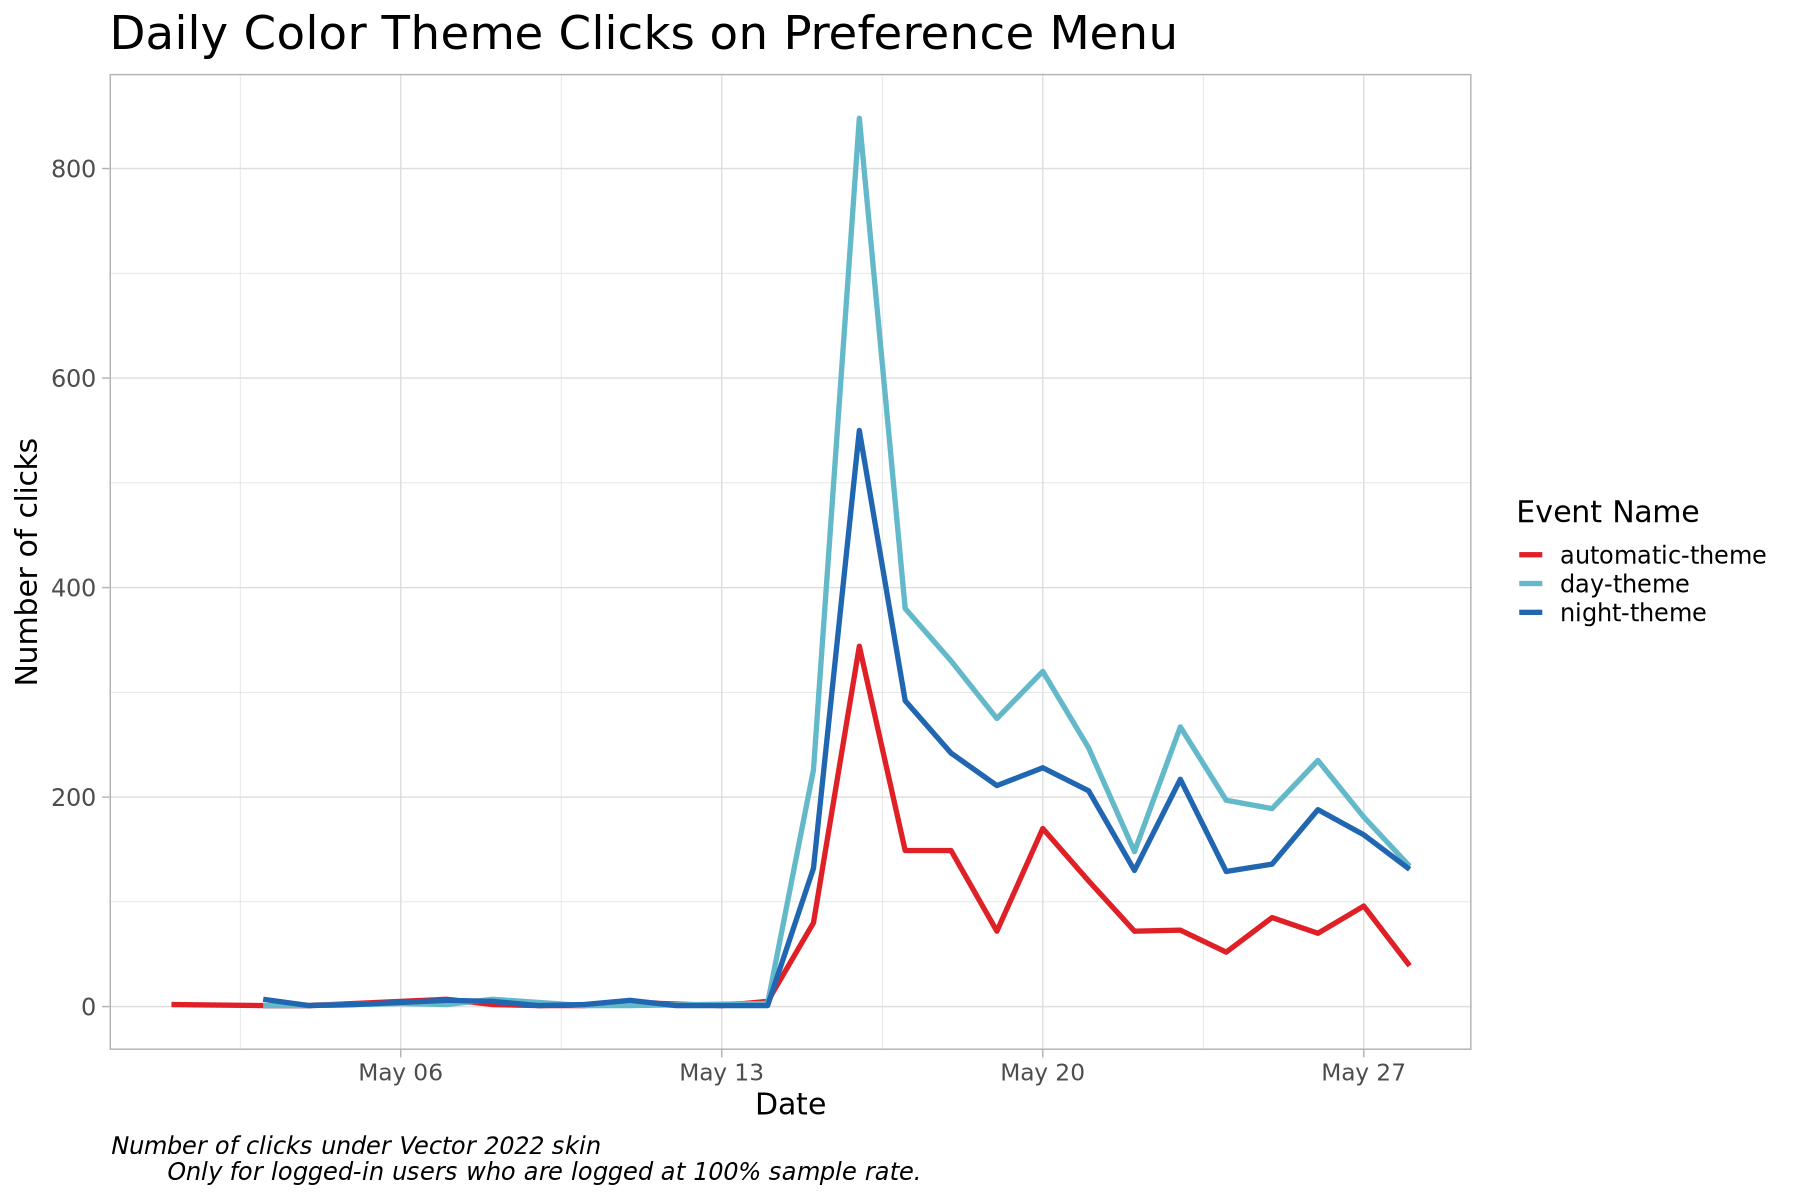

In [20]:
daily_g <- df_daily  %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=event_name)) +
   geom_line( size = 1.5) +
  scale_color_manual(values= c("#E02027", "#63B9CA", "#2166B1"), name = "Event Name")  +
  labs(title = 'Daily Color Theme Clicks on Preference Menu',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position='right', 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
daily_g

### Findings

The feature usage rose since May 15, 2024.   
The trend is consistent on a daily basis: there are more clicks to opt for the day theme, followed by clicks for the nigh them. The clicks for the automatic theme are fewest. It is expected as the automatic theme is the default.

In [22]:
df_click_summary <- df_daily %>%
    group_by(event_name) %>%
    summarize(sum_clicks=sum(clicks),.groups='drop')

In [23]:
df_click_summary %>%
 mutate(
     click_perctage = round(sum_clicks/sum(sum_clicks),3 )
     )

event_name      sum_clicks click_perctage
1 automatic-theme 1596       0.186         
2 day-theme       3996       0.466         
3 night-theme     2992       0.349

### Findings

Of all clicks to the color section of the new menu,
- 46.6% of them are clicks for day theme
- 34.9% of them are clicks for night theme
- 18.6% of them are clicks for automatic theme, which follows the OS settings. 

## What were they most likely to change it towards?

In [24]:
query <- "
SELECT  distinct event.token AS session_id,
event.name, 
RANK() OVER(PARTITION BY event.token ORDER BY dt DESC) AS desc_order_num
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>15
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-skin-theme-value-%' 
AND event.skin='vector-2022'
AND NOT event.isanon
AND NOT useragent.is_bot
"


In [25]:
df_session_click <- wmfdata$spark$run(query)

In [27]:
df_exclude <- df_session_click %>%
 filter(desc_order_num==1) %>%
 group_by(session_id) %>%
 summarize( cnt_last_event = n()) %>%
 filter(cnt_last_event>1)

In [28]:
df_exclude %>% nrow()

[1] 154

### Finding
154 sessions have more than one event of changing color theme with the same last timestamp. We will exclude these sessions from analysis since we cannot determine their most recent color theme.

In [29]:
 # Exclude sessions which have more than 1 event with the same last timestamp   
df_final <- df_session_click  %>%
   filter(desc_order_num==1) %>% 
   anti_join(df_exclude, join_by(session_id == session_id)) 

In [31]:
df_final <- df_final %>%
  mutate(
      event_name=case_when(
          name=='skin-client-pref-skin-theme-value-os' ~ 'automatic-theme',
          name=='skin-client-pref-skin-theme-value-day' ~ 'day-theme',
          name=='skin-client-pref-skin-theme-value-night' ~ 'night-theme',
          TRUE ~ 'others'
          )
      )

In [32]:
df_final %>% 
  group_by(event_name) %>%
  summarize(cnt_sessions=n_distinct(session_id), .groups='drop') %>%
  mutate(pct= cnt_sessions/sum(cnt_sessions))

event_name      cnt_sessions pct      
1 automatic-theme  287         0.1583012
2 day-theme       1189         0.6558191
3 night-theme      337         0.1858798

### Conclusion
For logged-in users:
- 65.6% of sessions opt for day theme.
- 18.6% of sessions opt for night theme.
- 15.8% of sessions opt for automatic theme (the OS setting).


## What percentage of users have changed their color theme?
###  How many logged-in sessions clicked color menu at least once in May, by May 28 ?

In [33]:
query <- "
select   event.skin,
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>15
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-skin-theme-value-%' 
AND NOT useragent.is_bot
AND NOT event.isAnon
GROUP BY event.skin
"

In [34]:
df_session <- wmfdata$spark$run(query)

In [35]:
df_session

skin        clicks sessions pages
1 vector-2022 8066   1967     3444

### Findings

1967 unique sessions have tried color menu at least once from May 16th to May 28th. 

### Note
31145 users have enabled beta feature preference cross wikis by May 28, 2024.They would be exposed to the font menu and color theme menu if they visited our website. But we don’t have data on how many of them have visited our website after we deployed the color theme menu in May.

## Curiosity questions

### For sessions which clicks for `automatic` theme ( ths OS theme), what's their OS preference? 

In [12]:
query <- "
select  event.dark_mode_setting, event.is_dark_mode_prepared_by_os,  event.is_dark_mode_on,
COUNT(1) AS clicks
FROM event.desktopwebuiactionstracking
WHERE year=2024 AND month=5 AND day>15
AND event.action='click' 
AND event.name='skin-client-pref-skin-theme-value-os' 
AND NOT useragent.is_bot
AND NOT event.isAnon
AND event.skin='vector-2022'
GROUP BY event.dark_mode_setting, event.is_dark_mode_prepared_by_os,  event.is_dark_mode_on
"

In [13]:
df_os <- wmfdata$spark$run(query)

In [14]:
threshold <- 100

In [15]:
df_os %>%
 arrange(dark_mode_setting) %>% 
 mutate(clicks = ifelse(clicks < threshold, glue("<{threshold}"), clicks))

dark_mode_setting is_dark_mode_prepared_by_os is_dark_mode_on clicks
1 0                  TRUE                       FALSE           656   
2 0                 FALSE                       FALSE           155   
3 1                  TRUE                        TRUE           352   
4 1                 FALSE                        TRUE           307   
5 2                 FALSE                       FALSE           <100  
6 2                  TRUE                        TRUE           <100